<a href="https://colab.research.google.com/github/lungnahahd/Tensorflow_Prac/blob/main/colorectal_histology.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow_datasets as tfds
import numpy as np
import tensorflow as tf
from tensorflow import keras
from functools import partial
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load("colorectal_histology",split=["train[:2%]", "train[20%:22%]","train[40%:46%]"])

# Data Augmentation (가운데 자르기 변형)
def central_crop(image):
  shape = tf.shape(image)
  min_dim = tf.reduce_min([shape[0], shape[1]])
  top_crop = (shape[0] - min_dim) // 4
  bottom_crop = shape[0] - top_crop
  left_crop = (shape[1] - min_dim) // 4
  right_crop = shape[1] - left_crop
  return image[top_crop:bottom_crop, left_crop:right_crop]

# Data Augmetation (일부를 랜덤하게 자르기 변형)
def random_crop(image):
  shape = tf.shape(image)
  min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
  return tf.image.random_crop(image,[min_dim,min_dim,3])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/colorectal_histology/2.0.0.incompleteV8ULYE/colorectal_histology-train.tfrecord


  0%|          | 0/5000 [00:00<?, ? examples/s]

Dataset colorectal_histology downloaded and prepared to /root/tensorflow_datasets/colorectal_histology/2.0.0. Subsequent calls will reuse this data.


#### Central_Crop 처리 과정

In [13]:
# 데이터를 MNIST 변형 계층에 넣기 위해 dataset prcessing 하는 부분
x_train_set, y_train_set = np.empty((0,150,150,3), np.uint8), np.empty((0,),np.uint8)
for i in train_set_raw:
  temp = central_crop(i['image'].numpy())
  x_train_set = np.append(x_train_set,np.expand_dims(temp, axis=0), axis=0)
  y_train_set = np.append(y_train_set,np.expand_dims(i['label'].numpy(), axis=0), axis=0)

x_test_set, y_test_set = np.empty((0,150,150,3), np.uint8), np.empty((0,),np.uint8)
for i in test_set_raw:
  temp = central_crop(i['image'].numpy())
  x_test_set = np.append(x_test_set,np.expand_dims(temp, axis=0), axis=0)
  y_test_set = np.append(y_test_set,np.expand_dims(i['label'].numpy(), axis=0), axis=0)

x_valid_set, y_valid_set = np.empty((0,150,150,3), np.uint8), np.empty((0,),np.uint8)
for i in valid_set_raw:
  temp = central_crop(i['image'].numpy())
  x_valid_set = np.append(x_valid_set,np.expand_dims(temp, axis=0), axis=0)
  y_valid_set = np.append(y_valid_set,np.expand_dims(i['label'].numpy(), axis=0), axis=0)

#### Random_Crop 처리 과정

In [18]:
# 데이터를 MNIST 변형 계층에 넣기 위해 dataset prcessing 하는 부분
x_train_set, y_train_set = np.empty((0,135,135,3), np.uint8), np.empty((0,),np.uint8)
for i in train_set_raw:
  temp = random_crop(i['image'].numpy())
  temp = tf.image.random_flip_left_right(temp)
  x_train_set = np.append(x_train_set,np.expand_dims(temp.numpy(), axis=0), axis=0)
  y_train_set = np.append(y_train_set,np.expand_dims(i['label'].numpy(), axis=0), axis=0)

x_test_set, y_test_set = np.empty((0,135,135,3), np.uint8), np.empty((0,),np.uint8)
for i in test_set_raw:
  temp = random_crop(i['image'].numpy())
  x_test_set = np.append(x_test_set,np.expand_dims(temp, axis=0), axis=0)
  y_test_set = np.append(y_test_set,np.expand_dims(i['label'].numpy(), axis=0), axis=0)

x_valid_set, y_valid_set = np.empty((0,135,135,3), np.uint8), np.empty((0,),np.uint8)
for i in valid_set_raw:
  temp = random_crop(i['image'].numpy())
  x_valid_set = np.append(x_valid_set,np.expand_dims(temp, axis=0), axis=0)
  y_valid_set = np.append(y_valid_set,np.expand_dims(i['label'].numpy(), axis=0), axis=0)

#### MNIST CNN 변형 모델

In [21]:

DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[135, 135, 3]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=8, activation='softmax'),
])

#### Central Augmentation fit 진행

In [14]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
early_stopping = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(x_train_set, y_train_set, epochs=10, validation_data=(x_valid_set, y_valid_set), callbacks=early_stopping)

Epoch 1/10
10/10 [==============================] - 103s 10s/step - loss: 2.7225 - accuracy: 0.1467 - val_loss: 2.0647 - val_accuracy: 0.2500
Epoch 2/10
10/10 [==============================] - 95s 10s/step - loss: 2.1014 - accuracy: 0.1067 - val_loss: 11.3286 - val_accuracy: 0.1500
Epoch 3/10
10/10 [==============================] - 94s 9s/step - loss: 4.8605 - accuracy: 0.1100 - val_loss: 2.0441 - val_accuracy: 0.2300
Epoch 4/10
10/10 [==============================] - 95s 10s/step - loss: 2.5425 - accuracy: 0.1567 - val_loss: 2.0931 - val_accuracy: 0.1400
Epoch 5/10
10/10 [==============================] - 94s 9s/step - loss: 2.6850 - accuracy: 0.1333 - val_loss: 2.0892 - val_accuracy: 0.1700
Epoch 6/10
10/10 [==============================] - 94s 9s/step - loss: 2.1917 - accuracy: 0.1367 - val_loss: 2.0308 - val_accuracy: 0.2800
Epoch 7/10
10/10 [==============================] - 97s 10s/step - loss: 2.0376 - accuracy: 0.1833 - val_loss: 1.9303 - val_accuracy: 0.1600
Epoch 8/10
10/

#### Central Augmentation 진행 결과

In [15]:
model.evaluate(x_test_set,y_test_set)

4/4 [==============================] - 20s 4s/step - loss: 2.0834 - accuracy: 0.0900


[2.083388566970825, 0.09000000357627869]

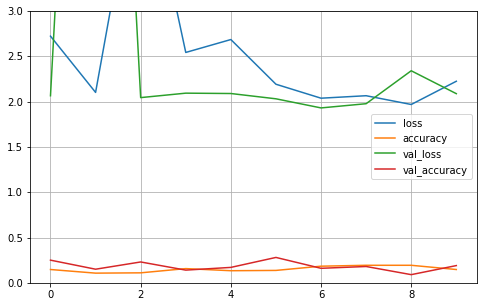

In [17]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,3)
#save_fig("keras_learning_curves_plot")
plt.show()

#### Random Augmentation fit 진행

In [22]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
early_stopping = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(x_train_set, y_train_set, epochs=10, validation_data=(x_valid_set, y_valid_set), callbacks=early_stopping)

Epoch 1/10
10/10 [==============================] - 79s 8s/step - loss: 29.0040 - accuracy: 0.1167 - val_loss: 2.0797 - val_accuracy: 0.1200
Epoch 2/10
10/10 [==============================] - 78s 8s/step - loss: 2.1811 - accuracy: 0.1000 - val_loss: 2.2243 - val_accuracy: 0.1200
Epoch 3/10
10/10 [==============================] - 76s 8s/step - loss: 2.1911 - accuracy: 0.1267 - val_loss: 2.0177 - val_accuracy: 0.2400
Epoch 4/10
10/10 [==============================] - 76s 8s/step - loss: 1.9964 - accuracy: 0.2133 - val_loss: 1.9204 - val_accuracy: 0.1800
Epoch 5/10
10/10 [==============================] - 76s 8s/step - loss: 1.9982 - accuracy: 0.1767 - val_loss: 2.0708 - val_accuracy: 0.0900
Epoch 6/10
10/10 [==============================] - 77s 8s/step - loss: 1.9958 - accuracy: 0.2000 - val_loss: 1.8227 - val_accuracy: 0.2000
Epoch 7/10
10/10 [==============================] - 76s 8s/step - loss: 1.9430 - accuracy: 0.2267 - val_loss: 1.9524 - val_accuracy: 0.2500
Epoch 8/10
10/10 [=

#### Random Augmentation 결과

In [23]:
model.evaluate(x_test_set,y_test_set)

4/4 [==============================] - 11s 2s/step - loss: 1.9768 - accuracy: 0.1400


[1.9768184423446655, 0.14000000059604645]

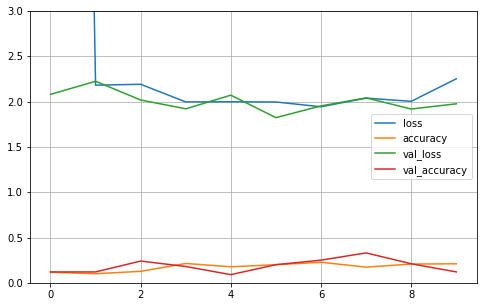

In [25]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,3)
#save_fig("keras_learning_curves_plot")
plt.show()